**<h2>Computing Water Potential Energy Surface Using Behler and Parinello Symmetry Functions** 

Importing relevant packages from PyTorch

In [1]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import os
import ase
from ase import Atoms
from ase.io import read

Loading the data (energies and geometries) for 1000 water molecule configurations in .xyz form

In [2]:
energies = np.genfromtxt('./water/energies.txt')
print("Energies file has",np.shape(energies),"entries")
#geometry_data =  read('./water/structures.xyz',index=':')
#print("Geometry file has",np.shape(geometry_data),"entries")
#print(geometry_data[0])
#geometry_data = np.array(geometry_data)

Energies file has (1000,) entries


In [3]:
# see https://education.molssi.org/python-data-analysis/01-numpy-arrays/index.html
#https://stackoverflow.com/questions/23353585/got-1-columns-instead-of-error-in-numpy

file_location = os.path.join('water', 'structures.xyz')
xyz_file = np.genfromtxt(fname=file_location, skip_header=2, dtype='unicode',invalid_raise = False)
# where invalid_raise = False was used to skip all lines in the xyz file that only have one column
symbols = xyz_file[:,0]
coordinates = (xyz_file[:,1:-1])
coordinates = coordinates.astype(np.float)

#print(symbols)
#print(coordinates)

<ipython-input-3-c38e52de7b08>:5: ConversionWarning: Some errors were detected !
    Line #6 (got 1 columns instead of 5)
    Line #11 (got 1 columns instead of 5)
    Line #16 (got 1 columns instead of 5)
    Line #21 (got 1 columns instead of 5)
    Line #26 (got 1 columns instead of 5)
    Line #31 (got 1 columns instead of 5)
    Line #36 (got 1 columns instead of 5)
    Line #41 (got 1 columns instead of 5)
    Line #46 (got 1 columns instead of 5)
    Line #51 (got 1 columns instead of 5)
    Line #56 (got 1 columns instead of 5)
    Line #61 (got 1 columns instead of 5)
    Line #66 (got 1 columns instead of 5)
    Line #71 (got 1 columns instead of 5)
    Line #76 (got 1 columns instead of 5)
    Line #81 (got 1 columns instead of 5)
    Line #86 (got 1 columns instead of 5)
    Line #91 (got 1 columns instead of 5)
    Line #96 (got 1 columns instead of 5)
    Line #101 (got 1 columns instead of 5)
    Line #106 (got 1 columns instead of 5)
    Line #111 (got 1 columns instead

In [4]:
## Alternatively loading the data in .npy form
# # The data was downloaded from http://www.quantum-machine.org/datasets/ (Densities dataset--> water.zip)
# # The data includes energies, densities and structure for water molecules
# #For each dataset, structures are given in with positions in Bohr and the energies are given in kcal/mol 
# energy_data = np.load('./water_102/dft_energies.npy')
# print("Energies file has",np.shape(energy_data),"entries")
# geometry_data =  np.load('./water-2/water_102/structures.npy')
# print("Geometry file has",np.shape(geometry_data),"entries")
# print(type(energy_data))
# print(type(geometry_data))

In [5]:
print(np.shape(coordinates))
print(type(coordinates))
print(coordinates[0])
print(energies[0])
# There is 1000 water molecules and each of them consists of 3 atoms, so we have 3000 atoms in total and each
# of them has 3 coordinates.
# Thus the coordinates array has 3000 lines, each of them corresponding to one atom (the first three lines
# correspopnd to the first water molecule) and 3 columns corresponding to the x, y and z coordinates respectively.

(3000, 3)
<class 'numpy.ndarray'>
[0.         0.769767   0.55746937]
-13815.2523726009


**<h2>Cutoff Function** 
    $$f_c(R_{ij}) = 
    \begin{cases}
        0.5 \times \big[\cos\big(\frac{\pi R_{ij}}{R_c}\big)+1\big]  & \text{for } R_{ij} \leq R_c\\
        0  & \text{for } R_{ij} > R_c
    \end{cases}
    $$
    
In the Behler and Parinello paper the Cutoff radius $R_c$ was taken to be $6$  Ångströms, or 11.3384 Bohr radii. (Remember, 1 Ångström is $10^{-10}$m)

In [6]:
def fc(R,Rc):
    if R <= Rc:
        fcutoff = 0.5 * (np.cos(np.pi*R/Rc)+1)
    else:
        fcutoff = 0
    return fcutoff

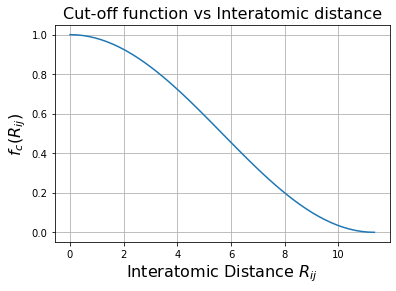

In [7]:
# Plotting fc as a function of interatomic distance Rij

Rc  = 11.3384 # Bohr

Rij     = np.linspace(0,Rc)
fcutoff = np.zeros(np.size(Rij))

for i in range(np.size(Rij)):
    fcutoff[i] = fc(Rij[i],Rc)

plt.plot(Rij,fcutoff)
plt.title('Cut-off function vs Interatomic distance', fontsize=16)
plt.xlabel('Interatomic Distance $R_{ij}$', fontsize=16)
plt.ylabel('$f_c(R_{ij})$', fontsize=16)
plt.grid()

**<h2>Pairwise Distances**

$$Dp = \begin{bmatrix} R_{00} & R_{01} & R_{02} \\ R_{10} & R_{11} & R_{12} \\ R_{20} & R_{21} & R_{22} \end{bmatrix} = \begin{bmatrix} 0 & R_{01} & R_{02} \\ R_{01} & 0 & R_{12} \\ R_{02} & R_{12} & 0 \end{bmatrix} $$

In [8]:
i = 0                                # i-th water molecule
coord = coordinates[3*i:3*(i+1),:]   # Let's take the coordinates of the ith water molecule in our dataset and compute
                                     # pairwise distances between all of its 3 atom

def pairwise_distances(coord):                       # we pass in the coordinates of the 3 atoms in the water molecule
    pairwise_dist_matrix = np.zeros(np.shape(coord))       # Initialise the matrix
    N = len(coord)
    for i in range(0,N-1):
#        print('i=',i)
        for j in range(i+1,N):
#            print(j)
#            pairwise_dist_matrix[i][j] = \
#            np.sqrt(  (coord[i][0] - coord[j][0] )**2 + (coord[i][1] - coord[j][1] )**2 +(coord[i][2] - coord[j][2] )**2   )
            pairwise_dist_matrix[i][j] =  np.sqrt(sum( (coord[i,:] - coord[j,:])**2 ))
            pairwise_dist_matrix[j][i] = pairwise_dist_matrix[i][j]

    return pairwise_dist_matrix

Dp = pairwise_distances(coord)
print(Dp)



[[0.         1.48093379 0.99367147]
 [1.48093379 0.         0.9075536 ]
 [0.99367147 0.9075536  0.        ]]


**<h2>From Cartesian to Generalised Coordinates**

**<h3>Radial Symmetry Functions**
    
<h3>$$G_i^1 = \sum_{j \neq i}^{\text{all}} e^{-\eta (R_{ij}-R_s)^2} f_c (R_{ij})$$

In [9]:
heta = 0.1
Rs   = 0
N    = len(coord)


def radial_BP_symm_func(Dp,N,heta,Rs):
    G_mu1 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)
    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(0,i):
            G_mu1[i] = G_mu1[i] + np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
        for j in range(i+1,N):
            G_mu1[i] = G_mu1[i] +  np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
    return G_mu1

Gmu1 = radial_BP_symm_func(Dp,N,heta,Rs)
print(Gmu1)

[1.65865495 1.67618952 1.79537284]


**<h3> Angular Symmetry Functions**

$$G_i^2 = 2^{1-\zeta} \sum_{j,k \neq i}^{\text{all}} (1+\lambda \cos \theta_{ijk})^\zeta \times e^{-\eta (R_{ij}^2+R_{ik}^2+R_{jk}^2 )} f_c (R_{ij})f_c (R_{ik})f_c (R_{jk})$$
    
with parameters $\lambda = +1, -1$, $\eta$ and $\zeta$

In [10]:
lambdaa = -1     #1
zeta    = 0.2
heta    = 0.1

N = len(coord)

def angular_BP_symm_func(coord,Dp,N,heta,Rs):
    G_mu2 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)

    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(N):           
            for k in range(N):
                if j != i and k !=i:
                    R_vec_ij = coord[i,:] - coord[j,:]
                    R_vec_jk = coord[k,:] - coord[k,:]
                    theta_ijk  = np.dot(R_vec_ij, R_vec_jk)/(Dp[i][j]*Dp[i][k])
                    G_mu2[i]   = G_mu2[i] + (  1 + lambdaa * np.cos(theta_ijk) )**zeta  \
                                * np.exp( -heta * (Dp[i][j]**2 + Dp[i][k]**2 + Dp[j][k]**2) ) \
                                * fc(Dp[i][j],Rc) * fc(Dp[i][k],Rc) * fc(Dp[j][k],Rc)            
        G_mu2[i]   = 2**(1-zeta) * G_mu2[i] 
    return G_mu2

Gmu2 = angular_BP_symm_func(coord,Dp,N,heta,Rs)
print(Gmu2)

[0. 0. 0.]


**<h2>Training and Test Set**

In [30]:
heta   = 0.3
Rs     = 0.1

lambdaa = 1     #-1
zeta    = 0.2


data_size            = 1000        # We have 1000 water molecule conformations
training_set_size    = 900

N                    = 3           # number of atoms per molecule
number_of_features   = 2           # number of features (symmetry functions) for each atom (we create one radial)
                                   # and one angular, but can create more by vaying the parameters η, λ, ζ, Rs etc.

    
G = np.zeros((len(coordinates), 2))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)

for i in range(data_size):
    coord = coordinates[N*i:N*(i+1),:]
    Dp    = pairwise_distances(coord)
    G[N*i:N*(i+1),0] = radial_BP_symm_func(Dp,N,heta,Rs)     
    G[N*i:N*(i+1),1] = angular_BP_symm_func(coord,Dp,N,heta,Rs)
    
# Computing variance and mean on the training data only!
G_train = G[:training_set_size,:]
var  = np.var(G_train,axis=0)
mean = np.mean(G_train,axis=0)

# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(G)[0]): 
    G[i,0] = (G[i,0]-mean[0])/var[0]
    G[i,1] = (G[i,1]-mean[1])/var[1]    


data_set = np.vsplit(G,1000)     # Going from a (3000,2) np.array to a (1000,3,2) list
#data_set = np.random.permutation(training_set)
data_set = torch.FloatTensor(data_set)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

# print(data_set[0])
# print(data_set[0][1][1])
labels = torch.FloatTensor(energies)            # turning energies into a (1000) tensor

# Splitting the dataset into training and test set
training_set         = data_set[:training_set_size]
test_set             = data_set[training_set_size:]

train_labels         = labels[:training_set_size]
test_labels          = labels[training_set_size:]

# Dataset
dataset = TensorDataset(training_set, train_labels)
#print(dataset[0])

# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                           shuffle=False, num_workers=2, drop_last=False) # ?????

print(np.shape(training_set))

torch.Size([900, 3, 2])


In [31]:
print(mean)

[1.38814747 2.80828035]


In [32]:
a = np.array([[1.0,2.0],[3.0,4.0],[5.0,6.0]])
# for i in range(3):
#     a[i,0] = a[i,0]/(sum(a[:,0])/3)
# print(a)

b = (sum(a[:,0])/3)
print(b)
print(type(b))
a[0,0] = a[0,0]/b
print(a)

3.0
<class 'numpy.float64'>
[[0.33333333 2.        ]
 [3.         4.        ]
 [5.         6.        ]]


**<h2>Building Neural Network Architecture**

In [33]:
class Subnets(nn.Module):
    def __init__(self):
        super(Subnets, self).__init__()
        self.fc1 = nn.Linear(2, 6)        # where fc stands for fully connected - from 2 input nodes to 3 hidden ones
        self.fc2 = nn.Linear(6, 3)        # from 3 hidden nodes to an output one
        self.fc3 = nn.Linear(3, 1)
#         self.fc4 = nn.Linear(10, 8)
#         self.fc5 = nn.Linear(8, 6)
#         self.fc6 = nn.Linear(6, 4)
#         self.fc7 = nn.Linear(4, 2)
#         self.fc8 = nn.Linear(2, 1)


    def forward(self, x):
        x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
        x = torch.tanh(self.fc2(x))
#         x = torch.tanh(self.fc3(x))
#         x = torch.tanh(self.fc4(x))
#         x = torch.tanh(self.fc5(x))
#         x = torch.tanh(self.fc6(x))
#         x = torch.tanh(self.fc7(x))
        x = self.fc3(x)                   # Using a linear function (identity function) for the subnet output layers
        return x

class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.network1 = Subnets()
        self.network2 = Subnets()
        self.network3 = Subnets()
        
#        self.fc_out = nn.Linear(3, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x1, x2, x3):
        x1 = self.network1(x1)
        x2 = self.network2(x2)
        x3 = self.network3(x3)
        
#         print(x1)
#         print(x2)
#         print(x3)
        
        x = torch.cat((x1, x2, x3), 0)
        x = torch.sum(x)                      #??????????????????????????? try average pooling?
        x = torch.reshape(x,[1])
        return x

    
model = BPNN()
N = 1
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)


# print(model)

# print('Network1')

# print('layer 1')
# print('weights')
# print(model.network1.fc1.weight)
# print('biases')
# print(model.network1.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network1.fc2.weight)
# print('biases')
# print(model.network1.fc2.bias)

# print('Network2')

# print('layer 1')
# print('weights')
# print(model.network2.fc1.weight)
# print('biases')
# print(model.network2.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network2.fc2.weight)
# print('biases')
# print(model.network2.fc2.bias)

# print('Network3')

# print('layer 1')
# print('weights')
# print(model.network3.fc1.weight)
# print('biases')
# print(model.network3.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network3.fc2.weight)
# print('biases')
# print(model.network3.fc2.bias)



x1 tensor([-4.0970, -0.8395])
x2 tensor([-2.0650, -0.1199])
x3 tensor([10.5482,  3.3864])
output
tensor([0.1337], grad_fn=<ViewBackward>)


In [34]:
# w11 = model.network1.fc1.weight
# b11 = model.network1.fc1.bias
# print(np.shape(w11))
# x1 = np.reshape(x1,(2,1))
# x1 = np.array(x1)
# print(np.shape(x1))

# w11 = w11.cpu().detach().numpy()
# b11 = b11.cpu().detach().numpy()
# #b11 = np.transpose(b11)
# b11 = np.reshape(b11,(3,1))
# print(np.shape(b11))
# print(type(x1))
# print(type(w11))

# a11 = np.matmul(w11,x1) + b11
# a11 = np.tanh(a11)
# print(a11)
# #print(torch.tensordot(w11,x1))


In [35]:
print('layer 1')
print('weights')
print(model.network1.fc1.weight)
print('biases')
print(model.network1.fc1.bias)

print('layer 2')
print('weights')
print(model.network1.fc2.weight)
print('biases')
print(model.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[-0.6381,  0.4771],
        [ 0.5923, -0.0456],
        [ 0.2929, -0.5798],
        [ 0.2722,  0.4924],
        [-0.1312,  0.0449],
        [-0.4068, -0.2930]], requires_grad=True)
biases
Parameter containing:
tensor([-0.2138, -0.1355,  0.1150,  0.5380,  0.6823,  0.1817],
       requires_grad=True)
layer 2
weights
Parameter containing:
tensor([[ 0.2068,  0.0406,  0.1469, -0.1824, -0.1114, -0.2965],
        [ 0.1926,  0.2281, -0.1192, -0.1350, -0.2958, -0.0427],
        [ 0.1876,  0.2303,  0.1243, -0.1394,  0.0299, -0.0637]],
       requires_grad=True)
biases
Parameter containing:
tensor([ 0.2704,  0.0057, -0.2873], requires_grad=True)


**<h2>Training the Neural Network**

In [36]:
net = BPNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)
nepochs = 100


train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)


train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#        inputs = torch.reshape(inputs,(3,2))    #  hard-coded !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        # zero the parameter gradients
        optimizer.zero_grad()

#         print(np.shape(inputs))
#         print(inputs)
        
        # forward + backward + optimize

        outputs = net(inputs[0][0],inputs[0][1],inputs[0][2])        #??????????????????????????????????????
        
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss))
        running_loss = 0.0    

print('Finished Training')

[1,     1] loss: 190893536.000
[1,     2] loss: 190837504.000
[1,     3] loss: 190759904.000
[1,     4] loss: 190764816.000
[1,     5] loss: 190777568.000
[1,     6] loss: 190732416.000
[1,     7] loss: 190643936.000
[1,     8] loss: 190575440.000
[1,     9] loss: 190586000.000
[1,    10] loss: 190587968.000
[1,    11] loss: 190528736.000
[1,    12] loss: 190466464.000
[1,    13] loss: 190405776.000
[1,    14] loss: 190257408.000
[1,    15] loss: 190310624.000
[1,    16] loss: 190291728.000
[1,    17] loss: 190358480.000
[1,    18] loss: 190328112.000
[1,    19] loss: 190237952.000
[1,    20] loss: 190068256.000
[1,    21] loss: 190245712.000
[1,    22] loss: 190826544.000
[1,    23] loss: 190085568.000
[1,    24] loss: 190050032.000
[1,    25] loss: 190021728.000
[1,    26] loss: 190043856.000
[1,    27] loss: 189871152.000
[1,    28] loss: 189966912.000
[1,    29] loss: 189911392.000
[1,    30] loss: 189938816.000
[1,    31] loss: 189877776.000
[1,    32] loss: 189836912.000
[1,    3

[1,   296] loss: 181208384.000
[1,   297] loss: 181224416.000
[1,   298] loss: 181102448.000
[1,   299] loss: 181086960.000
[1,   300] loss: 181100176.000
[1,   301] loss: 181066672.000
[1,   302] loss: 181054416.000
[1,   303] loss: 180792080.000
[1,   304] loss: 180869088.000
[1,   305] loss: 180998336.000
[1,   306] loss: 180894512.000
[1,   307] loss: 180918528.000
[1,   308] loss: 180882752.000
[1,   309] loss: 180736912.000
[1,   310] loss: 180761168.000
[1,   311] loss: 180655472.000
[1,   312] loss: 180652928.000
[1,   313] loss: 180674944.000
[1,   314] loss: 180599392.000
[1,   315] loss: 180609840.000
[1,   316] loss: 180464560.000
[1,   317] loss: 180587536.000
[1,   318] loss: 180387440.000
[1,   319] loss: 180474720.000
[1,   320] loss: 180445600.000
[1,   321] loss: 180275776.000
[1,   322] loss: 180416608.000
[1,   323] loss: 180333968.000
[1,   324] loss: 180354464.000
[1,   325] loss: 180245024.000
[1,   326] loss: 180309088.000
[1,   327] loss: 180164208.000
[1,   32

[1,   593] loss: 171878448.000
[1,   594] loss: 171750464.000
[1,   595] loss: 171806064.000
[1,   596] loss: 171824880.000
[1,   597] loss: 171800112.000
[1,   598] loss: 171618880.000
[1,   599] loss: 171583424.000
[1,   600] loss: 171677216.000
[1,   601] loss: 171662576.000
[1,   602] loss: 171571824.000
[1,   603] loss: 171466416.000
[1,   604] loss: 171339184.000
[1,   605] loss: 171499328.000
[1,   606] loss: 171454448.000
[1,   607] loss: 171396144.000
[1,   608] loss: 171265920.000
[1,   609] loss: 171309440.000
[1,   610] loss: 171273120.000
[1,   611] loss: 171208640.000
[1,   612] loss: 171220064.000
[1,   613] loss: 171170608.000
[1,   614] loss: 171019392.000
[1,   615] loss: 171176944.000
[1,   616] loss: 171031968.000
[1,   617] loss: 171135376.000
[1,   618] loss: 171035152.000
[1,   619] loss: 171173344.000
[1,   620] loss: 171109696.000
[1,   621] loss: 171037328.000
[1,   622] loss: 170885104.000
[1,   623] loss: 170859360.000
[1,   624] loss: 170814176.000
[1,   62

[1,   886] loss: 163094768.000
[1,   887] loss: 162914864.000
[1,   888] loss: 162900944.000
[1,   889] loss: 163031296.000
[1,   890] loss: 162947792.000
[1,   891] loss: 162834528.000
[1,   892] loss: 162885120.000
[1,   893] loss: 162821184.000
[1,   894] loss: 162766016.000
[1,   895] loss: 162744992.000
[1,   896] loss: 162828768.000
[1,   897] loss: 162740608.000
[1,   898] loss: 162685936.000
[1,   899] loss: 162719616.000
[1,   900] loss: 162614944.000
[2,     1] loss: 162609824.000
[2,     2] loss: 162575920.000
[2,     3] loss: 162510704.000
[2,     4] loss: 162516032.000
[2,     5] loss: 162528032.000
[2,     6] loss: 162483920.000
[2,     7] loss: 162405312.000
[2,     8] loss: 162332128.000
[2,     9] loss: 162352672.000
[2,    10] loss: 162355200.000
[2,    11] loss: 162301472.000
[2,    12] loss: 162245072.000
[2,    13] loss: 162190304.000
[2,    14] loss: 162054464.000
[2,    15] loss: 162105296.000
[2,    16] loss: 162089376.000
[2,    17] loss: 162152496.000
[2,    1

[2,   280] loss: 154471344.000
[2,   281] loss: 154529808.000
[2,   282] loss: 154489344.000
[2,   283] loss: 154470096.000
[2,   284] loss: 154372576.000
[2,   285] loss: 154371328.000
[2,   286] loss: 154317456.000
[2,   287] loss: 154306976.000
[2,   288] loss: 154294704.000
[2,   289] loss: 154272416.000
[2,   290] loss: 154157904.000
[2,   291] loss: 153991040.000
[2,   292] loss: 154144880.000
[2,   293] loss: 154183520.000
[2,   294] loss: 154115280.000
[2,   295] loss: 154084016.000
[2,   296] loss: 154012224.000
[2,   297] loss: 154028032.000
[2,   298] loss: 153916608.000
[2,   299] loss: 153903328.000
[2,   300] loss: 153916512.000
[2,   301] loss: 153886640.000
[2,   302] loss: 153876368.000
[2,   303] loss: 153635520.000
[2,   304] loss: 153707504.000
[2,   305] loss: 153827696.000
[2,   306] loss: 153732944.000
[2,   307] loss: 153756096.000
[2,   308] loss: 153724112.000
[2,   309] loss: 153590688.000
[2,   310] loss: 153614000.000
[2,   311] loss: 153517600.000
[2,   31

[2,   561] loss: 146660096.000
[2,   562] loss: 146617328.000
[2,   563] loss: 146589952.000
[2,   564] loss: 146588960.000
[2,   565] loss: 146546576.000
[2,   566] loss: 146494832.000
[2,   567] loss: 146373104.000
[2,   568] loss: 146137952.000
[2,   569] loss: 146407920.000
[2,   570] loss: 146363968.000
[2,   571] loss: 146259872.000
[2,   572] loss: 146239024.000
[2,   573] loss: 146177472.000
[2,   574] loss: 146313776.000
[2,   575] loss: 146190960.000
[2,   576] loss: 146224240.000
[2,   577] loss: 146096352.000
[2,   578] loss: 146029056.000
[2,   579] loss: 145915760.000
[2,   580] loss: 146135232.000
[2,   581] loss: 146040288.000
[2,   582] loss: 145815456.000
[2,   583] loss: 145942304.000
[2,   584] loss: 146015760.000
[2,   585] loss: 145889248.000
[2,   586] loss: 145867328.000
[2,   587] loss: 145723488.000
[2,   588] loss: 145773584.000
[2,   589] loss: 145837488.000
[2,   590] loss: 145718880.000
[2,   591] loss: 145509488.000
[2,   592] loss: 145666576.000
[2,   59

[2,   836] loss: 139152096.000
[2,   837] loss: 139111664.000
[2,   838] loss: 139002304.000
[2,   839] loss: 139042624.000
[2,   840] loss: 138914496.000
[2,   841] loss: 138980864.000
[2,   842] loss: 138974240.000
[2,   843] loss: 138914768.000
[2,   844] loss: 138982704.000
[2,   845] loss: 138915152.000
[2,   846] loss: 138916976.000
[2,   847] loss: 138795072.000
[2,   848] loss: 138728944.000
[2,   849] loss: 138564816.000
[2,   850] loss: 138725376.000
[2,   851] loss: 138685216.000
[2,   852] loss: 138617280.000
[2,   853] loss: 138503200.000
[2,   854] loss: 138584352.000
[2,   855] loss: 138550368.000
[2,   856] loss: 138591040.000
[2,   857] loss: 138532768.000
[2,   858] loss: 138485312.000
[2,   859] loss: 138431360.000
[2,   860] loss: 138439904.000
[2,   861] loss: 138476704.000
[2,   862] loss: 138392384.000
[2,   863] loss: 138412768.000
[2,   864] loss: 138215952.000
[2,   865] loss: 138328752.000
[2,   866] loss: 138287088.000
[2,   867] loss: 138324128.000
[2,   86

[3,   209] loss: 131891136.000
[3,   210] loss: 131920632.000
[3,   211] loss: 131861304.000
[3,   212] loss: 131919088.000
[3,   213] loss: 131715344.000
[3,   214] loss: 131742648.000
[3,   215] loss: 131757488.000
[3,   216] loss: 131587560.000
[3,   217] loss: 131690600.000
[3,   218] loss: 131743608.000
[3,   219] loss: 131623744.000
[3,   220] loss: 131696872.000
[3,   221] loss: 131592960.000
[3,   222] loss: 131407848.000
[3,   223] loss: 131671704.000
[3,   224] loss: 131503600.000
[3,   225] loss: 131542936.000
[3,   226] loss: 131462664.000
[3,   227] loss: 131446520.000
[3,   228] loss: 131360136.000
[3,   229] loss: 131426248.000
[3,   230] loss: 131490096.000
[3,   231] loss: 131379216.000
[3,   232] loss: 131361144.000
[3,   233] loss: 131259920.000
[3,   234] loss: 131340864.000
[3,   235] loss: 131327704.000
[3,   236] loss: 131307984.000
[3,   237] loss: 131259336.000
[3,   238] loss: 131203960.000
[3,   239] loss: 131062744.000
[3,   240] loss: 131074368.000
[3,   24

[3,   508] loss: 124320624.000
[3,   509] loss: 124418688.000
[3,   510] loss: 124330472.000
[3,   511] loss: 124129408.000
[3,   512] loss: 124247424.000
[3,   513] loss: 124196336.000
[3,   514] loss: 124286240.000
[3,   515] loss: 124168928.000
[3,   516] loss: 124100208.000
[3,   517] loss: 124225328.000
[3,   518] loss: 124113784.000
[3,   519] loss: 124170040.000
[3,   520] loss: 123988792.000
[3,   521] loss: 124064680.000
[3,   522] loss: 124111760.000
[3,   523] loss: 123810736.000
[3,   524] loss: 123944040.000
[3,   525] loss: 123932600.000
[3,   526] loss: 123946888.000
[3,   527] loss: 123918032.000
[3,   528] loss: 123865680.000
[3,   529] loss: 123759648.000
[3,   530] loss: 123787856.000
[3,   531] loss: 123812456.000
[3,   532] loss: 123763648.000
[3,   533] loss: 123816216.000
[3,   534] loss: 123617264.000
[3,   535] loss: 123730120.000
[3,   536] loss: 123709504.000
[3,   537] loss: 123689152.000
[3,   538] loss: 123523424.000
[3,   539] loss: 123637152.000
[3,   54

[3,   789] loss: 117487160.000
[3,   790] loss: 117514536.000
[3,   791] loss: 117356320.000
[3,   792] loss: 117430664.000
[3,   793] loss: 117290848.000
[3,   794] loss: 117323680.000
[3,   795] loss: 117391912.000
[3,   796] loss: 117377864.000
[3,   797] loss: 117266096.000
[3,   798] loss: 117328328.000
[3,   799] loss: 117205152.000
[3,   800] loss: 117292832.000
[3,   801] loss: 117112136.000
[3,   802] loss: 117140968.000
[3,   803] loss: 117137584.000
[3,   804] loss: 117168912.000
[3,   805] loss: 117057880.000
[3,   806] loss: 117107760.000
[3,   807] loss: 117006664.000
[3,   808] loss: 117072016.000
[3,   809] loss: 116912608.000
[3,   810] loss: 117065576.000
[3,   811] loss: 117001656.000
[3,   812] loss: 116957696.000
[3,   813] loss: 116864296.000
[3,   814] loss: 116836152.000
[3,   815] loss: 116869488.000
[3,   816] loss: 116931592.000
[3,   817] loss: 116851368.000
[3,   818] loss: 116758472.000
[3,   819] loss: 116845416.000
[3,   820] loss: 116808832.000
[3,   82

[4,   165] loss: 111040056.000
[4,   166] loss: 110927840.000
[4,   167] loss: 110928040.000
[4,   168] loss: 110959352.000
[4,   169] loss: 110772792.000
[4,   170] loss: 110873128.000
[4,   171] loss: 110899824.000
[4,   172] loss: 110630752.000
[4,   173] loss: 110736368.000
[4,   174] loss: 110696496.000
[4,   175] loss: 110765016.000
[4,   176] loss: 110612832.000
[4,   177] loss: 110766168.000
[4,   178] loss: 110709480.000
[4,   179] loss: 110649464.000
[4,   180] loss: 110584696.000
[4,   181] loss: 110506968.000
[4,   182] loss: 110491528.000
[4,   183] loss: 110539024.000
[4,   184] loss: 110479640.000
[4,   185] loss: 110506248.000
[4,   186] loss: 110418104.000
[4,   187] loss: 110426640.000
[4,   188] loss: 110358720.000
[4,   189] loss: 110494920.000
[4,   190] loss: 110434240.000
[4,   191] loss: 110435712.000
[4,   192] loss: 110300232.000
[4,   193] loss: 110297744.000
[4,   194] loss: 110315536.000
[4,   195] loss: 110327840.000
[4,   196] loss: 110197832.000
[4,   19

[4,   432] loss: 104927392.000
[4,   433] loss: 104855864.000
[4,   434] loss: 104756688.000
[4,   435] loss: 104703400.000
[4,   436] loss: 104782072.000
[4,   437] loss: 104658776.000
[4,   438] loss: 104768976.000
[4,   439] loss: 104674856.000
[4,   440] loss: 104706056.000
[4,   441] loss: 104719584.000
[4,   442] loss: 104631640.000
[4,   443] loss: 104588176.000
[4,   444] loss: 104535784.000
[4,   445] loss: 104669888.000
[4,   446] loss: 104345144.000
[4,   447] loss: 104607328.000
[4,   448] loss: 104500648.000
[4,   449] loss: 104535344.000
[4,   450] loss: 104412752.000
[4,   451] loss: 104509968.000
[4,   452] loss: 104368448.000
[4,   453] loss: 104304488.000
[4,   454] loss: 104388888.000
[4,   455] loss: 104321184.000
[4,   456] loss: 104355624.000
[4,   457] loss: 104317200.000
[4,   458] loss: 104366896.000
[4,   459] loss: 104179000.000
[4,   460] loss: 104305888.000
[4,   461] loss: 104253376.000
[4,   462] loss: 104212336.000
[4,   463] loss: 104191640.000
[4,   46

[4,   719] loss: 98525144.000
[4,   720] loss: 98481416.000
[4,   721] loss: 98501304.000
[4,   722] loss: 98490024.000
[4,   723] loss: 98507464.000
[4,   724] loss: 98514232.000
[4,   725] loss: 98406632.000
[4,   726] loss: 98424344.000
[4,   727] loss: 98293672.000
[4,   728] loss: 98451048.000
[4,   729] loss: 98275136.000
[4,   730] loss: 98372440.000
[4,   731] loss: 98322928.000
[4,   732] loss: 98345456.000
[4,   733] loss: 98304104.000
[4,   734] loss: 98221128.000
[4,   735] loss: 98184216.000
[4,   736] loss: 98205176.000
[4,   737] loss: 98116240.000
[4,   738] loss: 98213328.000
[4,   739] loss: 98184256.000
[4,   740] loss: 98001800.000
[4,   741] loss: 98101000.000
[4,   742] loss: 98067632.000
[4,   743] loss: 97982352.000
[4,   744] loss: 97932728.000
[4,   745] loss: 98036144.000
[4,   746] loss: 97865848.000
[4,   747] loss: 97933328.000
[4,   748] loss: 97961376.000
[4,   749] loss: 97943184.000
[4,   750] loss: 97838256.000
[4,   751] loss: 97899392.000
[4,   752]

[5,   103] loss: 92527888.000
[5,   104] loss: 92547072.000
[5,   105] loss: 92364560.000
[5,   106] loss: 92515144.000
[5,   107] loss: 92441824.000
[5,   108] loss: 92485528.000
[5,   109] loss: 92306104.000
[5,   110] loss: 92228504.000
[5,   111] loss: 92324496.000
[5,   112] loss: 92245032.000
[5,   113] loss: 92282888.000
[5,   114] loss: 92277280.000
[5,   115] loss: 92181864.000
[5,   116] loss: 92280808.000
[5,   117] loss: 92210672.000
[5,   118] loss: 92217984.000
[5,   119] loss: 92123344.000
[5,   120] loss: 92112272.000
[5,   121] loss: 92219392.000
[5,   122] loss: 92038600.000
[5,   123] loss: 92033352.000
[5,   124] loss: 92115776.000
[5,   125] loss: 92015440.000
[5,   126] loss: 92044968.000
[5,   127] loss: 92104976.000
[5,   128] loss: 92049352.000
[5,   129] loss: 92005168.000
[5,   130] loss: 91974184.000
[5,   131] loss: 91849744.000
[5,   132] loss: 91915776.000
[5,   133] loss: 91917328.000
[5,   134] loss: 91919200.000
[5,   135] loss: 91791592.000
[5,   136]

[5,   395] loss: 86591912.000
[5,   396] loss: 86546480.000
[5,   397] loss: 86513160.000
[5,   398] loss: 86523408.000
[5,   399] loss: 86464352.000
[5,   400] loss: 86476144.000
[5,   401] loss: 86351752.000
[5,   402] loss: 86403848.000
[5,   403] loss: 86405704.000
[5,   404] loss: 86424240.000
[5,   405] loss: 86404616.000
[5,   406] loss: 86377840.000
[5,   407] loss: 86353112.000
[5,   408] loss: 86236088.000
[5,   409] loss: 86297928.000
[5,   410] loss: 86139152.000
[5,   411] loss: 86217280.000
[5,   412] loss: 86264728.000
[5,   413] loss: 86101800.000
[5,   414] loss: 86199840.000
[5,   415] loss: 86188536.000
[5,   416] loss: 86047384.000
[5,   417] loss: 86156088.000
[5,   418] loss: 86133296.000
[5,   419] loss: 86090816.000
[5,   420] loss: 85966472.000
[5,   421] loss: 85996936.000
[5,   422] loss: 86011768.000
[5,   423] loss: 86005992.000
[5,   424] loss: 85974008.000
[5,   425] loss: 86009104.000
[5,   426] loss: 85817248.000
[5,   427] loss: 85917040.000
[5,   428]

[5,   684] loss: 80856944.000
[5,   685] loss: 80902312.000
[5,   686] loss: 80861296.000
[5,   687] loss: 80741704.000
[5,   688] loss: 80842400.000
[5,   689] loss: 80666800.000
[5,   690] loss: 80706504.000
[5,   691] loss: 80717696.000
[5,   692] loss: 80737384.000
[5,   693] loss: 80620440.000
[5,   694] loss: 80692408.000
[5,   695] loss: 80703304.000
[5,   696] loss: 80643384.000
[5,   697] loss: 80630856.000
[5,   698] loss: 80565032.000
[5,   699] loss: 80636928.000
[5,   700] loss: 80550488.000
[5,   701] loss: 80596456.000
[5,   702] loss: 80528192.000
[5,   703] loss: 80487832.000
[5,   704] loss: 80422936.000
[5,   705] loss: 80428808.000
[5,   706] loss: 80417496.000
[5,   707] loss: 80424744.000
[5,   708] loss: 80304456.000
[5,   709] loss: 80296456.000
[5,   710] loss: 80364328.000
[5,   711] loss: 80297872.000
[5,   712] loss: 80348952.000
[5,   713] loss: 80253024.000
[5,   714] loss: 80331584.000
[5,   715] loss: 80164936.000
[5,   716] loss: 80250240.000
[5,   717]

[6,    58] loss: 75710056.000
[6,    59] loss: 75661696.000
[6,    60] loss: 75638640.000
[6,    61] loss: 75666008.000
[6,    62] loss: 75619224.000
[6,    63] loss: 75621456.000
[6,    64] loss: 75589000.000
[6,    65] loss: 75515832.000
[6,    66] loss: 75555208.000
[6,    67] loss: 75441272.000
[6,    68] loss: 75472960.000
[6,    69] loss: 75481704.000
[6,    70] loss: 75487368.000
[6,    71] loss: 75389976.000
[6,    72] loss: 75465512.000
[6,    73] loss: 75457728.000
[6,    74] loss: 75335992.000
[6,    75] loss: 75326704.000
[6,    76] loss: 75378088.000
[6,    77] loss: 75311376.000
[6,    78] loss: 75311840.000
[6,    79] loss: 75320240.000
[6,    80] loss: 75248360.000
[6,    81] loss: 75040088.000
[6,    82] loss: 75205784.000
[6,    83] loss: 75129096.000
[6,    84] loss: 75190680.000
[6,    85] loss: 75132024.000
[6,    86] loss: 75157728.000
[6,    87] loss: 75195592.000
[6,    88] loss: 75133176.000
[6,    89] loss: 75099200.000
[6,    90] loss: 75100488.000
[6,    91]

[6,   349] loss: 70266504.000
[6,   350] loss: 70359968.000
[6,   351] loss: 70385680.000
[6,   352] loss: 70363984.000
[6,   353] loss: 70310600.000
[6,   354] loss: 70277704.000
[6,   355] loss: 70263296.000
[6,   356] loss: 70220328.000
[6,   357] loss: 70181096.000
[6,   358] loss: 70153024.000
[6,   359] loss: 70252816.000
[6,   360] loss: 70069224.000
[6,   361] loss: 70200816.000
[6,   362] loss: 70125808.000
[6,   363] loss: 70096160.000
[6,   364] loss: 70082728.000
[6,   365] loss: 70072200.000
[6,   366] loss: 70095472.000
[6,   367] loss: 70069296.000
[6,   368] loss: 70088112.000
[6,   369] loss: 69958192.000
[6,   370] loss: 69934480.000
[6,   371] loss: 69848848.000
[6,   372] loss: 69977016.000
[6,   373] loss: 69918768.000
[6,   374] loss: 69929608.000
[6,   375] loss: 69912952.000
[6,   376] loss: 69847416.000
[6,   377] loss: 69831584.000
[6,   378] loss: 69880344.000
[6,   379] loss: 69685160.000
[6,   380] loss: 69854272.000
[6,   381] loss: 69794296.000
[6,   382]

[6,   641] loss: 65282832.000
[6,   642] loss: 65240468.000
[6,   643] loss: 65249968.000
[6,   644] loss: 65261624.000
[6,   645] loss: 65262716.000
[6,   646] loss: 65174400.000
[6,   647] loss: 65215624.000
[6,   648] loss: 65097920.000
[6,   649] loss: 65110448.000
[6,   650] loss: 65094420.000
[6,   651] loss: 65114796.000
[6,   652] loss: 65065176.000
[6,   653] loss: 65055520.000
[6,   654] loss: 65012960.000
[6,   655] loss: 65071272.000
[6,   656] loss: 64999716.000
[6,   657] loss: 64998632.000
[6,   658] loss: 64917484.000
[6,   659] loss: 64968764.000
[6,   660] loss: 64881828.000
[6,   661] loss: 64963688.000
[6,   662] loss: 64919332.000
[6,   663] loss: 64862252.000
[6,   664] loss: 64807320.000
[6,   665] loss: 64879688.000
[6,   666] loss: 64866216.000
[6,   667] loss: 64765352.000
[6,   668] loss: 64853216.000
[6,   669] loss: 64788012.000
[6,   670] loss: 64673624.000
[6,   671] loss: 64783596.000
[6,   672] loss: 64763772.000
[6,   673] loss: 64687320.000
[6,   674]

[7,    17] loss: 60676220.000
[7,    18] loss: 60661812.000
[7,    19] loss: 60613616.000
[7,    20] loss: 60520544.000
[7,    21] loss: 60623424.000
[7,    22] loss: 60547744.000
[7,    23] loss: 60536408.000
[7,    24] loss: 60517216.000
[7,    25] loss: 60497040.000
[7,    26] loss: 60516076.000
[7,    27] loss: 60418420.000
[7,    28] loss: 60475640.000
[7,    29] loss: 60445992.000
[7,    30] loss: 60463276.000
[7,    31] loss: 60430732.000
[7,    32] loss: 60409648.000
[7,    33] loss: 60400540.000
[7,    34] loss: 60397320.000
[7,    35] loss: 60362960.000
[7,    36] loss: 60252448.000
[7,    37] loss: 60257696.000
[7,    38] loss: 60318008.000
[7,    39] loss: 60282472.000
[7,    40] loss: 60241580.000
[7,    41] loss: 60245104.000
[7,    42] loss: 60263396.000
[7,    43] loss: 60242632.000
[7,    44] loss: 60172640.000
[7,    45] loss: 60186108.000
[7,    46] loss: 60098956.000
[7,    47] loss: 60170096.000
[7,    48] loss: 60095940.000
[7,    49] loss: 60104260.000
[7,    50]

[7,   303] loss: 55957616.000
[7,   304] loss: 56002596.000
[7,   305] loss: 56076668.000
[7,   306] loss: 56021000.000
[7,   307] loss: 56036484.000
[7,   308] loss: 56018704.000
[7,   309] loss: 55939676.000
[7,   310] loss: 55955264.000
[7,   311] loss: 55898608.000
[7,   312] loss: 55899336.000
[7,   313] loss: 55913636.000
[7,   314] loss: 55873736.000
[7,   315] loss: 55881744.000
[7,   316] loss: 55803088.000
[7,   317] loss: 55873596.000
[7,   318] loss: 55764364.000
[7,   319] loss: 55815084.000
[7,   320] loss: 55801016.000
[7,   321] loss: 55708716.000
[7,   322] loss: 55789132.000
[7,   323] loss: 55745296.000
[7,   324] loss: 55758772.000
[7,   325] loss: 55700084.000
[7,   326] loss: 55737808.000
[7,   327] loss: 55659380.000
[7,   328] loss: 55641796.000
[7,   329] loss: 55671272.000
[7,   330] loss: 55597668.000
[7,   331] loss: 55566540.000
[7,   332] loss: 55635776.000
[7,   333] loss: 55543192.000
[7,   334] loss: 55619832.000
[7,   335] loss: 55577696.000
[7,   336]

[7,   593] loss: 51619608.000
[7,   594] loss: 51551392.000
[7,   595] loss: 51583788.000
[7,   596] loss: 51596016.000
[7,   597] loss: 51584336.000
[7,   598] loss: 51486944.000
[7,   599] loss: 51469456.000
[7,   600] loss: 51522736.000
[7,   601] loss: 51516632.000
[7,   602] loss: 51468840.000
[7,   603] loss: 51413016.000
[7,   604] loss: 51345236.000
[7,   605] loss: 51434824.000
[7,   606] loss: 51412176.000
[7,   607] loss: 51382156.000
[7,   608] loss: 51312772.000
[7,   609] loss: 51338484.000
[7,   610] loss: 51320516.000
[7,   611] loss: 51287112.000
[7,   612] loss: 51295244.000
[7,   613] loss: 51270088.000
[7,   614] loss: 51189244.000
[7,   615] loss: 51277360.000
[7,   616] loss: 51199924.000
[7,   617] loss: 51258412.000
[7,   618] loss: 51205484.000
[7,   619] loss: 51283000.000
[7,   620] loss: 51250052.000
[7,   621] loss: 51212328.000
[7,   622] loss: 51130936.000
[7,   623] loss: 51118756.000
[7,   624] loss: 51095944.000
[7,   625] loss: 51121956.000
[7,   626]

[7,   876] loss: 47530912.000
[7,   877] loss: 47455516.000
[7,   878] loss: 47451728.000
[7,   879] loss: 47477148.000
[7,   880] loss: 47375648.000
[7,   881] loss: 47386692.000
[7,   882] loss: 47422484.000
[7,   883] loss: 47421864.000
[7,   884] loss: 47306132.000
[7,   885] loss: 47360908.000
[7,   886] loss: 47379076.000
[7,   887] loss: 47283860.000
[7,   888] loss: 47278100.000
[7,   889] loss: 47350088.000
[7,   890] loss: 47306832.000
[7,   891] loss: 47247540.000
[7,   892] loss: 47276528.000
[7,   893] loss: 47243828.000
[7,   894] loss: 47215848.000
[7,   895] loss: 47206252.000
[7,   896] loss: 47253096.000
[7,   897] loss: 47207348.000
[7,   898] loss: 47179648.000
[7,   899] loss: 47199516.000
[7,   900] loss: 47144880.000
[8,     1] loss: 47143852.000
[8,     2] loss: 47127328.000
[8,     3] loss: 47093948.000
[8,     4] loss: 47098532.000
[8,     5] loss: 47106728.000
[8,     6] loss: 47084700.000
[8,     7] loss: 47044112.000
[8,     8] loss: 47006452.000
[8,     9]

[8,   276] loss: 43250704.000
[8,   277] loss: 43242832.000
[8,   278] loss: 43162300.000
[8,   279] loss: 43275896.000
[8,   280] loss: 43262152.000
[8,   281] loss: 43294684.000
[8,   282] loss: 43274856.000
[8,   283] loss: 43266276.000
[8,   284] loss: 43216264.000
[8,   285] loss: 43217200.000
[8,   286] loss: 43190292.000
[8,   287] loss: 43186352.000
[8,   288] loss: 43181448.000
[8,   289] loss: 43171244.000
[8,   290] loss: 43112272.000
[8,   291] loss: 43025636.000
[8,   292] loss: 43108580.000
[8,   293] loss: 43130600.000
[8,   294] loss: 43096104.000
[8,   295] loss: 43081168.000
[8,   296] loss: 43044792.000
[8,   297] loss: 43054724.000
[8,   298] loss: 42997420.000
[8,   299] loss: 42991988.000
[8,   300] loss: 43000544.000
[8,   301] loss: 42986340.000
[8,   302] loss: 42982488.000
[8,   303] loss: 42856824.000
[8,   304] loss: 42896428.000
[8,   305] loss: 42961516.000
[8,   306] loss: 42913036.000
[8,   307] loss: 42926844.000
[8,   308] loss: 42911524.000
[8,   309]

[8,   565] loss: 39544672.000
[8,   566] loss: 39519272.000
[8,   567] loss: 39457544.000
[8,   568] loss: 39336980.000
[8,   569] loss: 39478588.000
[8,   570] loss: 39457244.000
[8,   571] loss: 39404684.000
[8,   572] loss: 39395348.000
[8,   573] loss: 39364884.000
[8,   574] loss: 39437112.000
[8,   575] loss: 39374836.000
[8,   576] loss: 39393596.000
[8,   577] loss: 39328704.000
[8,   578] loss: 39295268.000
[8,   579] loss: 39237972.000
[8,   580] loss: 39353312.000
[8,   581] loss: 39305508.000
[8,   582] loss: 39190388.000
[8,   583] loss: 39257652.000
[8,   584] loss: 39297228.000
[8,   585] loss: 39233096.000
[8,   586] loss: 39223200.000
[8,   587] loss: 39150112.000
[8,   588] loss: 39177552.000
[8,   589] loss: 39212168.000
[8,   590] loss: 39152140.000
[8,   591] loss: 39045120.000
[8,   592] loss: 39127992.000
[8,   593] loss: 39142240.000
[8,   594] loss: 39083072.000
[8,   595] loss: 39111540.000
[8,   596] loss: 39122424.000
[8,   597] loss: 39112516.000
[8,   598]

[8,   851] loss: 35912384.000
[8,   852] loss: 35879212.000
[8,   853] loss: 35822568.000
[8,   854] loss: 35865232.000
[8,   855] loss: 35849336.000
[8,   856] loss: 35871432.000
[8,   857] loss: 35843168.000
[8,   858] loss: 35820412.000
[8,   859] loss: 35794372.000
[8,   860] loss: 35800112.000
[8,   861] loss: 35820196.000
[8,   862] loss: 35778704.000
[8,   863] loss: 35790460.000
[8,   864] loss: 35691804.000
[8,   865] loss: 35750512.000
[8,   866] loss: 35730692.000
[8,   867] loss: 35750928.000
[8,   868] loss: 35731804.000
[8,   869] loss: 35742784.000
[8,   870] loss: 35693588.000
[8,   871] loss: 35686972.000
[8,   872] loss: 35705936.000
[8,   873] loss: 35601388.000
[8,   874] loss: 35610880.000
[8,   875] loss: 35618316.000
[8,   876] loss: 35662184.000
[8,   877] loss: 35597112.000
[8,   878] loss: 35594064.000
[8,   879] loss: 35616336.000
[8,   880] loss: 35528688.000
[8,   881] loss: 35538504.000
[8,   882] loss: 35569752.000
[8,   883] loss: 35569472.000
[8,   884]

[9,   228] loss: 32597750.000
[9,   229] loss: 32632020.000
[9,   230] loss: 32665144.000
[9,   231] loss: 32611194.000
[9,   232] loss: 32603526.000
[9,   233] loss: 32554424.000
[9,   234] loss: 32596060.000
[9,   235] loss: 32590796.000
[9,   236] loss: 32582306.000
[9,   237] loss: 32559394.000
[9,   238] loss: 32533120.000
[9,   239] loss: 32464132.000
[9,   240] loss: 32471238.000
[9,   241] loss: 32504040.000
[9,   242] loss: 32464332.000
[9,   243] loss: 32449288.000
[9,   244] loss: 32473476.000
[9,   245] loss: 32463276.000
[9,   246] loss: 32481762.000
[9,   247] loss: 32414452.000
[9,   248] loss: 32342108.000
[9,   249] loss: 32423972.000
[9,   250] loss: 32394584.000
[9,   251] loss: 32399808.000
[9,   252] loss: 32404094.000
[9,   253] loss: 32363498.000
[9,   254] loss: 32316250.000
[9,   255] loss: 32275980.000
[9,   256] loss: 32354210.000
[9,   257] loss: 32333972.000
[9,   258] loss: 32230314.000
[9,   259] loss: 32270532.000
[9,   260] loss: 32307656.000
[9,   261]

[9,   517] loss: 29453994.000
[9,   518] loss: 29400964.000
[9,   519] loss: 29429586.000
[9,   520] loss: 29342652.000
[9,   521] loss: 29380814.000
[9,   522] loss: 29405000.000
[9,   523] loss: 29259806.000
[9,   524] loss: 29325884.000
[9,   525] loss: 29321570.000
[9,   526] loss: 29329776.000
[9,   527] loss: 29316980.000
[9,   528] loss: 29292788.000
[9,   529] loss: 29242472.000
[9,   530] loss: 29257440.000
[9,   531] loss: 29270636.000
[9,   532] loss: 29248164.000
[9,   533] loss: 29274958.000
[9,   534] loss: 29179514.000
[9,   535] loss: 29235628.000
[9,   536] loss: 29226842.000
[9,   537] loss: 29218206.000
[9,   538] loss: 29138920.000
[9,   539] loss: 29195438.000
[9,   540] loss: 29188104.000
[9,   541] loss: 29199818.000
[9,   542] loss: 29109670.000
[9,   543] loss: 29134092.000
[9,   544] loss: 29137982.000
[9,   545] loss: 29080098.000
[9,   546] loss: 29089864.000
[9,   547] loss: 29113286.000
[9,   548] loss: 29119388.000
[9,   549] loss: 29051974.000
[9,   550]

[9,   803] loss: 26396766.000
[9,   804] loss: 26412844.000
[9,   805] loss: 26361346.000
[9,   806] loss: 26386220.000
[9,   807] loss: 26339448.000
[9,   808] loss: 26371676.000
[9,   809] loss: 26297236.000
[9,   810] loss: 26371024.000
[9,   811] loss: 26341894.000
[9,   812] loss: 26322240.000
[9,   813] loss: 26279140.000
[9,   814] loss: 26266996.000
[9,   815] loss: 26284006.000
[9,   816] loss: 26314666.000
[9,   817] loss: 26277818.000
[9,   818] loss: 26234974.000
[9,   819] loss: 26277398.000
[9,   820] loss: 26261250.000
[9,   821] loss: 26220730.000
[9,   822] loss: 26239666.000
[9,   823] loss: 26146664.000
[9,   824] loss: 26209310.000
[9,   825] loss: 26167112.000
[9,   826] loss: 26166412.000
[9,   827] loss: 26190136.000
[9,   828] loss: 26159150.000
[9,   829] loss: 26108676.000
[9,   830] loss: 26097052.000
[9,   831] loss: 26084122.000
[9,   832] loss: 26138814.000
[9,   833] loss: 26100904.000
[9,   834] loss: 26049340.000
[9,   835] loss: 26105444.000
[9,   836]

[10,   172] loss: 23665526.000
[10,   173] loss: 23715550.000
[10,   174] loss: 23698280.000
[10,   175] loss: 23731150.000
[10,   176] loss: 23661906.000
[10,   177] loss: 23734024.000
[10,   178] loss: 23708958.000
[10,   179] loss: 23682348.000
[10,   180] loss: 23653546.000
[10,   181] loss: 23618774.000
[10,   182] loss: 23612804.000
[10,   183] loss: 23635920.000
[10,   184] loss: 23609634.000
[10,   185] loss: 23623112.000
[10,   186] loss: 23583524.000
[10,   187] loss: 23588646.000
[10,   188] loss: 23558424.000
[10,   189] loss: 23622552.000
[10,   190] loss: 23595666.000
[10,   191] loss: 23597516.000
[10,   192] loss: 23536076.000
[10,   193] loss: 23536096.000
[10,   194] loss: 23545476.000
[10,   195] loss: 23552330.000
[10,   196] loss: 23493446.000
[10,   197] loss: 23496306.000
[10,   198] loss: 23490020.000
[10,   199] loss: 23523816.000
[10,   200] loss: 23516344.000
[10,   201] loss: 23481568.000
[10,   202] loss: 23418510.000
[10,   203] loss: 23448302.000
[10,   2

[10,   445] loss: 21257746.000
[10,   446] loss: 21112660.000
[10,   447] loss: 21231828.000
[10,   448] loss: 21184922.000
[10,   449] loss: 21201682.000
[10,   450] loss: 21147622.000
[10,   451] loss: 21192526.000
[10,   452] loss: 21129958.000
[10,   453] loss: 21102324.000
[10,   454] loss: 21141424.000
[10,   455] loss: 21112104.000
[10,   456] loss: 21128728.000
[10,   457] loss: 21112590.000
[10,   458] loss: 21136082.000
[10,   459] loss: 21052710.000
[10,   460] loss: 21110902.000
[10,   461] loss: 21088420.000
[10,   462] loss: 21071122.000
[10,   463] loss: 21062946.000
[10,   464] loss: 21062354.000
[10,   465] loss: 20986124.000
[10,   466] loss: 20988978.000
[10,   467] loss: 21010630.000
[10,   468] loss: 21045756.000
[10,   469] loss: 20982278.000
[10,   470] loss: 21020676.000
[10,   471] loss: 21009644.000
[10,   472] loss: 20978072.000
[10,   473] loss: 20925604.000
[10,   474] loss: 20951584.000
[10,   475] loss: 20908918.000
[10,   476] loss: 20956752.000
[10,   4

[10,   721] loss: 18829336.000
[10,   722] loss: 18825514.000
[10,   723] loss: 18834252.000
[10,   724] loss: 18838330.000
[10,   725] loss: 18792402.000
[10,   726] loss: 18801252.000
[10,   727] loss: 18745272.000
[10,   728] loss: 18815152.000
[10,   729] loss: 18739404.000
[10,   730] loss: 18783014.000
[10,   731] loss: 18762492.000
[10,   732] loss: 18773450.000
[10,   733] loss: 18756496.000
[10,   734] loss: 18721366.000
[10,   735] loss: 18706360.000
[10,   736] loss: 18716624.000
[10,   737] loss: 18678924.000
[10,   738] loss: 18722414.000
[10,   739] loss: 18710838.000
[10,   740] loss: 18632340.000
[10,   741] loss: 18676722.000
[10,   742] loss: 18663278.000
[10,   743] loss: 18627198.000
[10,   744] loss: 18606670.000
[10,   745] loss: 18652876.000
[10,   746] loss: 18579736.000
[10,   747] loss: 18610258.000
[10,   748] loss: 18623600.000
[10,   749] loss: 18616772.000
[10,   750] loss: 18572152.000
[10,   751] loss: 18599896.000
[10,   752] loss: 18562802.000
[10,   7

[11,    87] loss: 16724410.000
[11,    88] loss: 16695939.000
[11,    89] loss: 16680883.000
[11,    90] loss: 16682446.000
[11,    91] loss: 16689419.000
[11,    92] loss: 16632434.000
[11,    93] loss: 16639285.000
[11,    94] loss: 16608984.000
[11,    95] loss: 16641428.000
[11,    96] loss: 16633119.000
[11,    97] loss: 16611189.000
[11,    98] loss: 16593927.000
[11,    99] loss: 16625019.000
[11,   100] loss: 16601765.000
[11,   101] loss: 16574297.000
[11,   102] loss: 16604312.000
[11,   103] loss: 16569885.000
[11,   104] loss: 16579092.000
[11,   105] loss: 16502994.000
[11,   106] loss: 16567762.000
[11,   107] loss: 16537844.000
[11,   108] loss: 16557429.000
[11,   109] loss: 16482641.000
[11,   110] loss: 16450954.000
[11,   111] loss: 16492601.000
[11,   112] loss: 16460121.000
[11,   113] loss: 16477209.000
[11,   114] loss: 16475933.000
[11,   115] loss: 16436721.000
[11,   116] loss: 16479612.000
[11,   117] loss: 16451073.000
[11,   118] loss: 16455256.000
[11,   1

[11,   358] loss: 14641616.000
[11,   359] loss: 14688184.000
[11,   360] loss: 14605251.000
[11,   361] loss: 14666319.000
[11,   362] loss: 14632993.000
[11,   363] loss: 14620399.000
[11,   364] loss: 14615224.000
[11,   365] loss: 14611379.000
[11,   366] loss: 14622954.000
[11,   367] loss: 14611947.000
[11,   368] loss: 14621497.000
[11,   369] loss: 14563145.000
[11,   370] loss: 14553279.000
[11,   371] loss: 14515170.000
[11,   372] loss: 14574581.000
[11,   373] loss: 14548965.000
[11,   374] loss: 14554858.000
[11,   375] loss: 14548205.000
[11,   376] loss: 14519263.000
[11,   377] loss: 14512997.000
[11,   378] loss: 14536184.000
[11,   379] loss: 14448187.000
[11,   380] loss: 14526200.000
[11,   381] loss: 14499808.000
[11,   382] loss: 14517544.000
[11,   383] loss: 14506926.000
[11,   384] loss: 14457254.000
[11,   385] loss: 14471798.000
[11,   386] loss: 14483190.000
[11,   387] loss: 14439837.000
[11,   388] loss: 14443630.000
[11,   389] loss: 14467675.000
[11,   3

[11,   633] loss: 12746518.000
[11,   634] loss: 12753617.000
[11,   635] loss: 12750521.000
[11,   636] loss: 12740814.000
[11,   637] loss: 12722939.000
[11,   638] loss: 12737008.000
[11,   639] loss: 12714859.000
[11,   640] loss: 12718062.000
[11,   641] loss: 12722131.000
[11,   642] loss: 12704379.000
[11,   643] loss: 12709510.000
[11,   644] loss: 12715604.000
[11,   645] loss: 12717032.000
[11,   646] loss: 12679010.000
[11,   647] loss: 12698149.000
[11,   648] loss: 12647178.000
[11,   649] loss: 12653645.000
[11,   650] loss: 12647525.000
[11,   651] loss: 12657446.000
[11,   652] loss: 12636518.000
[11,   653] loss: 12633207.000
[11,   654] loss: 12615407.000
[11,   655] loss: 12642052.000
[11,   656] loss: 12611467.000
[11,   657] loss: 12611931.000
[11,   658] loss: 12577150.000
[11,   659] loss: 12600677.000
[11,   660] loss: 12563349.000
[11,   661] loss: 12600323.000
[11,   662] loss: 12581742.000
[11,   663] loss: 12557569.000
[11,   664] loss: 12534345.000
[11,   6

[12,     1] loss: 11077944.000
[12,     2] loss: 11070755.000
[12,     3] loss: 11055398.000
[12,     4] loss: 11058437.000
[12,     5] loss: 11063224.000
[12,     6] loss: 11053365.000
[12,     7] loss: 11034523.000
[12,     8] loss: 11017109.000
[12,     9] loss: 11024118.000
[12,    10] loss: 11026434.000
[12,    11] loss: 11014089.000
[12,    12] loss: 11001057.000
[12,    13] loss: 10988448.000
[12,    14] loss: 10954762.000
[12,    15] loss: 10969629.000
[12,    16] loss: 10967145.000
[12,    17] loss: 10985218.000
[12,    18] loss: 10980020.000
[12,    19] loss: 10960464.000
[12,    20] loss: 10921844.000
[12,    21] loss: 10966517.000
[12,    22] loss: 10935280.000
[12,    23] loss: 10931405.000
[12,    24] loss: 10924193.000
[12,    25] loss: 10916564.000
[12,    26] loss: 10925581.000
[12,    27] loss: 10885051.000
[12,    28] loss: 10910293.000
[12,    29] loss: 10898645.000
[12,    30] loss: 10906919.000
[12,    31] loss: 10894048.000
[12,    32] loss: 10886043.000
[12,    

[12,   271] loss: 9517508.000
[12,   272] loss: 9490509.000
[12,   273] loss: 9488602.000
[12,   274] loss: 9485750.000
[12,   275] loss: 9478184.000
[12,   276] loss: 9449206.000
[12,   277] loss: 9446342.000
[12,   278] loss: 9409538.000
[12,   279] loss: 9463440.000
[12,   280] loss: 9457835.000
[12,   281] loss: 9473868.000
[12,   282] loss: 9465411.000
[12,   283] loss: 9462221.000
[12,   284] loss: 9439662.000
[12,   285] loss: 9440916.000
[12,   286] loss: 9429158.000
[12,   287] loss: 9428138.000
[12,   288] loss: 9426669.000
[12,   289] loss: 9422718.000
[12,   290] loss: 9395991.000
[12,   291] loss: 9356388.000
[12,   292] loss: 9395907.000
[12,   293] loss: 9407004.000
[12,   294] loss: 9391711.000
[12,   295] loss: 9385559.000
[12,   296] loss: 9369404.000
[12,   297] loss: 9374851.000
[12,   298] loss: 9348933.000
[12,   299] loss: 9347219.000
[12,   300] loss: 9352033.000
[12,   301] loss: 9346228.000
[12,   302] loss: 9345255.000
[12,   303] loss: 9287524.000
[12,   304

[12,   555] loss: 8008850.500
[12,   556] loss: 7968187.500
[12,   557] loss: 7982440.500
[12,   558] loss: 8010215.500
[12,   559] loss: 8000572.500
[12,   560] loss: 7985823.500
[12,   561] loss: 8006529.000
[12,   562] loss: 7998026.000
[12,   563] loss: 7993116.000
[12,   564] loss: 7994364.000
[12,   565] loss: 7985956.000
[12,   566] loss: 7975362.000
[12,   567] loss: 7948462.500
[12,   568] loss: 7895205.500
[12,   569] loss: 7959528.500
[12,   570] loss: 7950764.500
[12,   571] loss: 7927997.000
[12,   572] loss: 7924621.000
[12,   573] loss: 7911777.000
[12,   574] loss: 7944993.500
[12,   575] loss: 7917870.500
[12,   576] loss: 7927100.500
[12,   577] loss: 7898822.500
[12,   578] loss: 7884661.000
[12,   579] loss: 7859820.500
[12,   580] loss: 7912298.500
[12,   581] loss: 7891693.500
[12,   582] loss: 7840968.000
[12,   583] loss: 7871882.500
[12,   584] loss: 7890426.000
[12,   585] loss: 7862514.500
[12,   586] loss: 7858900.500
[12,   587] loss: 7827011.500
[12,   588

[12,   830] loss: 6700271.500
[12,   831] loss: 6694398.000
[12,   832] loss: 6722788.000
[12,   833] loss: 6704256.000
[12,   834] loss: 6678807.500
[12,   835] loss: 6707913.000
[12,   836] loss: 6703052.500
[12,   837] loss: 6695601.000
[12,   838] loss: 6673029.000
[12,   839] loss: 6683280.000
[12,   840] loss: 6656611.500
[12,   841] loss: 6672560.000
[12,   842] loss: 6672519.500
[12,   843] loss: 6660905.500
[12,   844] loss: 6677197.500
[12,   845] loss: 6663804.500
[12,   846] loss: 6665614.500
[12,   847] loss: 6640340.000
[12,   848] loss: 6627291.000
[12,   849] loss: 6592858.500
[12,   850] loss: 6629327.500
[12,   851] loss: 6621952.500
[12,   852] loss: 6608519.500
[12,   853] loss: 6585032.500
[12,   854] loss: 6604142.000
[12,   855] loss: 6598130.500
[12,   856] loss: 6608419.000
[12,   857] loss: 6597102.000
[12,   858] loss: 6588150.500
[12,   859] loss: 6577797.500
[12,   860] loss: 6581063.500
[12,   861] loss: 6590492.000
[12,   862] loss: 6573520.000
[12,   863

[13,   204] loss: 5553948.500
[13,   205] loss: 5581448.000
[13,   206] loss: 5541789.500
[13,   207] loss: 5563872.000
[13,   208] loss: 5560551.000
[13,   209] loss: 5537942.000
[13,   210] loss: 5545330.500
[13,   211] loss: 5534518.000
[13,   212] loss: 5547708.500
[13,   213] loss: 5507327.000
[13,   214] loss: 5514255.000
[13,   215] loss: 5518636.000
[13,   216] loss: 5485243.000
[13,   217] loss: 5507639.000
[13,   218] loss: 5519829.000
[13,   219] loss: 5496662.000
[13,   220] loss: 5512952.500
[13,   221] loss: 5493049.500
[13,   222] loss: 5456617.500
[13,   223] loss: 5511838.500
[13,   224] loss: 5478831.500
[13,   225] loss: 5488207.500
[13,   226] loss: 5473164.500
[13,   227] loss: 5471213.500
[13,   228] loss: 5454939.000
[13,   229] loss: 5469760.500
[13,   230] loss: 5484131.500
[13,   231] loss: 5462842.500
[13,   232] loss: 5460501.000
[13,   233] loss: 5441217.000
[13,   234] loss: 5459054.500
[13,   235] loss: 5457708.000
[13,   236] loss: 5455030.000
[13,   237

[13,   489] loss: 4486797.000
[13,   490] loss: 4517219.000
[13,   491] loss: 4517866.500
[13,   492] loss: 4485990.000
[13,   493] loss: 4494677.500
[13,   494] loss: 4490322.500
[13,   495] loss: 4501073.000
[13,   496] loss: 4480792.000
[13,   497] loss: 4484790.500
[13,   498] loss: 4477617.000
[13,   499] loss: 4464616.500
[13,   500] loss: 4478592.500
[13,   501] loss: 4460758.500
[13,   502] loss: 4453250.000
[13,   503] loss: 4468814.500
[13,   504] loss: 4444981.500
[13,   505] loss: 4464298.500
[13,   506] loss: 4454449.500
[13,   507] loss: 4446678.500
[13,   508] loss: 4438395.500
[13,   509] loss: 4458222.000
[13,   510] loss: 4442812.000
[13,   511] loss: 4406149.500
[13,   512] loss: 4429676.500
[13,   513] loss: 4421315.500
[13,   514] loss: 4439576.500
[13,   515] loss: 4418699.500
[13,   516] loss: 4407014.500
[13,   517] loss: 4431901.000
[13,   518] loss: 4412133.000
[13,   519] loss: 4424022.000
[13,   520] loss: 4391136.500
[13,   521] loss: 4406703.000
[13,   522

[13,   782] loss: 3553556.250
[13,   783] loss: 3552348.750
[13,   784] loss: 3577366.000
[13,   785] loss: 3561978.000
[13,   786] loss: 3571173.500
[13,   787] loss: 3571871.250
[13,   788] loss: 3554141.750
[13,   789] loss: 3548952.000
[13,   790] loss: 3554926.000
[13,   791] loss: 3528666.750
[13,   792] loss: 3542780.500
[13,   793] loss: 3519742.500
[13,   794] loss: 3526645.500
[13,   795] loss: 3539704.250
[13,   796] loss: 3538480.750
[13,   797] loss: 3520310.500
[13,   798] loss: 3532314.750
[13,   799] loss: 3512183.500
[13,   800] loss: 3528586.250
[13,   801] loss: 3498514.500
[13,   802] loss: 3504713.000
[13,   803] loss: 3505342.000
[13,   804] loss: 3511978.500
[13,   805] loss: 3493986.000
[13,   806] loss: 3503821.000
[13,   807] loss: 3487563.500
[13,   808] loss: 3500071.000
[13,   809] loss: 3473757.000
[13,   810] loss: 3501386.500
[13,   811] loss: 3491547.750
[13,   812] loss: 3485171.250
[13,   813] loss: 3470270.500
[13,   814] loss: 3466633.000
[13,   815

[14,   164] loss: 2790332.000
[14,   165] loss: 2803763.750
[14,   166] loss: 2787112.750
[14,   167] loss: 2788296.500
[14,   168] loss: 2794421.500
[14,   169] loss: 2766027.000
[14,   170] loss: 2783061.250
[14,   171] loss: 2788446.750
[14,   172] loss: 2747066.750
[14,   173] loss: 2764887.000
[14,   174] loss: 2759745.000
[14,   175] loss: 2771724.250
[14,   176] loss: 2748844.250
[14,   177] loss: 2774222.000
[14,   178] loss: 2766410.250
[14,   179] loss: 2758077.500
[14,   180] loss: 2749006.000
[14,   181] loss: 2737916.500
[14,   182] loss: 2736636.750
[14,   183] loss: 2745264.000
[14,   184] loss: 2737066.500
[14,   185] loss: 2742410.500
[14,   186] loss: 2729688.000
[14,   187] loss: 2732183.000
[14,   188] loss: 2722654.750
[14,   189] loss: 2745244.500
[14,   190] loss: 2736833.750
[14,   191] loss: 2738223.500
[14,   192] loss: 2718067.500
[14,   193] loss: 2718827.500
[14,   194] loss: 2722770.750
[14,   195] loss: 2725855.750
[14,   196] loss: 2706597.000
[14,   197

[14,   477] loss: 2087821.750
[14,   478] loss: 2081868.500
[14,   479] loss: 2085827.000
[14,   480] loss: 2047914.750
[14,   481] loss: 2062508.250
[14,   482] loss: 2070659.125
[14,   483] loss: 2073448.125
[14,   484] loss: 2068619.250
[14,   485] loss: 2049572.500
[14,   486] loss: 2068116.500
[14,   487] loss: 2061894.125
[14,   488] loss: 2057927.500
[14,   489] loss: 2035660.125
[14,   490] loss: 2056442.875
[14,   491] loss: 2057154.250
[14,   492] loss: 2035938.875
[14,   493] loss: 2042066.125
[14,   494] loss: 2039409.875
[14,   495] loss: 2046928.250
[14,   496] loss: 2033540.000
[14,   497] loss: 2036507.375
[14,   498] loss: 2031952.750
[14,   499] loss: 2023467.375
[14,   500] loss: 2033158.500
[14,   501] loss: 2021417.500
[14,   502] loss: 2016638.500
[14,   503] loss: 2027397.750
[14,   504] loss: 2011629.750
[14,   505] loss: 2024909.500
[14,   506] loss: 2018552.750
[14,   507] loss: 2013599.750
[14,   508] loss: 2008304.125
[14,   509] loss: 2021920.125
[14,   510

[14,   772] loss: 1526689.500
[14,   773] loss: 1525574.750
[14,   774] loss: 1509392.250
[14,   775] loss: 1523004.250
[14,   776] loss: 1504472.375
[14,   777] loss: 1514332.125
[14,   778] loss: 1519436.625
[14,   779] loss: 1522618.625
[14,   780] loss: 1507605.125
[14,   781] loss: 1512287.500
[14,   782] loss: 1496883.000
[14,   783] loss: 1496364.500
[14,   784] loss: 1512876.000
[14,   785] loss: 1503140.625
[14,   786] loss: 1509375.375
[14,   787] loss: 1510095.375
[14,   788] loss: 1498833.500
[14,   789] loss: 1495729.000
[14,   790] loss: 1499873.875
[14,   791] loss: 1483098.250
[14,   792] loss: 1492518.000
[14,   793] loss: 1477841.500
[14,   794] loss: 1482579.750
[14,   795] loss: 1491310.875
[14,   796] loss: 1490781.375
[14,   797] loss: 1479256.875
[14,   798] loss: 1487304.125
[14,   799] loss: 1474519.250
[14,   800] loss: 1485418.250
[14,   801] loss: 1466197.000
[14,   802] loss: 1470468.875
[14,   803] loss: 1471144.000
[14,   804] loss: 1475703.000
[14,   805

[15,   147] loss: 1107306.125
[15,   148] loss: 1107579.500
[15,   149] loss: 1101593.750
[15,   150] loss: 1108755.500
[15,   151] loss: 1106252.000
[15,   152] loss: 1104935.625
[15,   153] loss: 1101202.250
[15,   154] loss: 1107392.375
[15,   155] loss: 1097219.375
[15,   156] loss: 1102770.750
[15,   157] loss: 1097049.625
[15,   158] loss: 1082583.375
[15,   159] loss: 1097913.125
[15,   160] loss: 1093611.500
[15,   161] loss: 1082337.500
[15,   162] loss: 1095199.000
[15,   163] loss: 1081201.875
[15,   164] loss: 1083390.250
[15,   165] loss: 1092016.875
[15,   166] loss: 1081884.375
[15,   167] loss: 1082871.875
[15,   168] loss: 1086940.625
[15,   169] loss: 1069507.375
[15,   170] loss: 1080357.250
[15,   171] loss: 1083961.625
[15,   172] loss: 1058467.250
[15,   173] loss: 1069788.250
[15,   174] loss: 1066836.875
[15,   175] loss: 1074542.750
[15,   176] loss: 1060560.000
[15,   177] loss: 1076594.750
[15,   178] loss: 1071983.250
[15,   179] loss: 1067050.625
[15,   180

[15,   429] loss: 775978.625
[15,   430] loss: 777651.875
[15,   431] loss: 764289.188
[15,   432] loss: 774718.000
[15,   433] loss: 769466.500
[15,   434] loss: 761871.562
[15,   435] loss: 758210.688
[15,   436] loss: 765806.188
[15,   437] loss: 756174.625
[15,   438] loss: 766455.812
[15,   439] loss: 759302.875
[15,   440] loss: 762847.000
[15,   441] loss: 764883.500
[15,   442] loss: 758266.812
[15,   443] loss: 755446.188
[15,   444] loss: 751878.688
[15,   445] loss: 764176.438
[15,   446] loss: 737528.688
[15,   447] loss: 760605.438
[15,   448] loss: 752412.250
[15,   449] loss: 756240.875
[15,   450] loss: 746720.438
[15,   451] loss: 755848.562
[15,   452] loss: 744730.250
[15,   453] loss: 740208.188
[15,   454] loss: 748214.875
[15,   455] loss: 743367.312
[15,   456] loss: 747155.938
[15,   457] loss: 744782.500
[15,   458] loss: 749868.062
[15,   459] loss: 734887.625
[15,   460] loss: 746458.875
[15,   461] loss: 742900.875
[15,   462] loss: 740317.375
[15,   463] lo

[15,   732] loss: 506969.031
[15,   733] loss: 504786.656
[15,   734] loss: 499639.125
[15,   735] loss: 497786.750
[15,   736] loss: 500063.062
[15,   737] loss: 494509.750
[15,   738] loss: 502208.906
[15,   739] loss: 500915.594
[15,   740] loss: 488734.812
[15,   741] loss: 496543.188
[15,   742] loss: 494950.719
[15,   743] loss: 489684.219
[15,   744] loss: 486953.188
[15,   745] loss: 495053.781
[15,   746] loss: 483789.531
[15,   747] loss: 489323.469
[15,   748] loss: 492084.438
[15,   749] loss: 491574.906
[15,   750] loss: 484938.125
[15,   751] loss: 490028.719
[15,   752] loss: 484617.219
[15,   753] loss: 482943.562
[15,   754] loss: 485048.312
[15,   755] loss: 482505.250
[15,   756] loss: 480285.531
[15,   757] loss: 487969.094
[15,   758] loss: 478303.281
[15,   759] loss: 480564.406
[15,   760] loss: 481592.625
[15,   761] loss: 481050.625
[15,   762] loss: 481442.188
[15,   763] loss: 482248.875
[15,   764] loss: 470772.875
[15,   765] loss: 480416.844
[15,   766] lo

[16,   122] loss: 309493.375
[16,   123] loss: 309860.750
[16,   124] loss: 315341.469
[16,   125] loss: 310168.500
[16,   126] loss: 312562.875
[16,   127] loss: 316751.312
[16,   128] loss: 314176.656
[16,   129] loss: 312274.688
[16,   130] loss: 311148.250
[16,   131] loss: 304618.844
[16,   132] loss: 309106.688
[16,   133] loss: 309871.625
[16,   134] loss: 310656.000
[16,   135] loss: 303947.625
[16,   136] loss: 306417.375
[16,   137] loss: 310383.906
[16,   138] loss: 303961.625
[16,   139] loss: 303210.469
[16,   140] loss: 305099.812
[16,   141] loss: 305522.844
[16,   142] loss: 304544.469
[16,   143] loss: 299022.062
[16,   144] loss: 303098.625
[16,   145] loss: 295168.312
[16,   146] loss: 299530.656
[16,   147] loss: 299965.875
[16,   148] loss: 300287.938
[16,   149] loss: 297357.188
[16,   150] loss: 301263.750
[16,   151] loss: 300139.188
[16,   152] loss: 299633.281
[16,   153] loss: 297869.719
[16,   154] loss: 301273.406
[16,   155] loss: 296157.031
[16,   156] lo

[16,   416] loss: 180472.297
[16,   417] loss: 186051.531
[16,   418] loss: 185564.078
[16,   419] loss: 184163.359
[16,   420] loss: 179014.938
[16,   421] loss: 180971.312
[16,   422] loss: 182217.266
[16,   423] loss: 182516.688
[16,   424] loss: 181610.812
[16,   425] loss: 183794.750
[16,   426] loss: 175582.281
[16,   427] loss: 180687.266
[16,   428] loss: 175102.203
[16,   429] loss: 180325.469
[16,   430] loss: 181284.688
[16,   431] loss: 175009.859
[16,   432] loss: 180170.406
[16,   433] loss: 177793.172
[16,   434] loss: 174301.359
[16,   435] loss: 172701.125
[16,   436] loss: 176486.141
[16,   437] loss: 172026.469
[16,   438] loss: 177098.781
[16,   439] loss: 173818.156
[16,   440] loss: 175665.766
[16,   441] loss: 176796.438
[16,   442] loss: 173771.734
[16,   443] loss: 172573.719
[16,   444] loss: 171018.594
[16,   445] loss: 177060.141
[16,   446] loss: 164500.750
[16,   447] loss: 175645.297
[16,   448] loss: 171867.734
[16,   449] loss: 173851.531
[16,   450] lo

[16,   709] loss: 97422.016
[16,   710] loss: 100256.336
[16,   711] loss: 98374.117
[16,   712] loss: 100629.594
[16,   713] loss: 97712.414
[16,   714] loss: 100932.172
[16,   715] loss: 95554.039
[16,   716] loss: 98975.984
[16,   717] loss: 99391.180
[16,   718] loss: 98829.188
[16,   719] loss: 96910.000
[16,   720] loss: 96001.938
[16,   721] loss: 97085.188
[16,   722] loss: 97192.938
[16,   723] loss: 98205.727
[16,   724] loss: 98885.070
[16,   725] loss: 95963.211
[16,   726] loss: 96979.938
[16,   727] loss: 93372.617
[16,   728] loss: 98751.219
[16,   729] loss: 93709.523
[16,   730] loss: 97200.852
[16,   731] loss: 96109.688
[16,   732] loss: 97278.805
[16,   733] loss: 96442.391
[16,   734] loss: 94316.766
[16,   735] loss: 93631.219
[16,   736] loss: 94737.109
[16,   737] loss: 92446.281
[16,   738] loss: 95909.977
[16,   739] loss: 95462.898
[16,   740] loss: 90302.008
[16,   741] loss: 93792.648
[16,   742] loss: 93219.297
[16,   743] loss: 91056.602
[16,   744] loss:

[17,   109] loss: 46879.863
[17,   110] loss: 45488.059
[17,   111] loss: 47995.227
[17,   112] loss: 46546.379
[17,   113] loss: 47750.785
[17,   114] loss: 47974.262
[17,   115] loss: 46167.070
[17,   116] loss: 48762.473
[17,   117] loss: 47512.504
[17,   118] loss: 48031.176
[17,   119] loss: 46239.699
[17,   120] loss: 46338.027
[17,   121] loss: 49127.598
[17,   122] loss: 45382.730
[17,   123] loss: 45609.777
[17,   124] loss: 47814.398
[17,   125] loss: 45899.715
[17,   126] loss: 46909.891
[17,   127] loss: 48628.863
[17,   128] loss: 47710.250
[17,   129] loss: 47058.488
[17,   130] loss: 46707.906
[17,   131] loss: 44283.121
[17,   132] loss: 46091.141
[17,   133] loss: 46472.664
[17,   134] loss: 46864.215
[17,   135] loss: 44364.949
[17,   136] loss: 45397.711
[17,   137] loss: 47018.672
[17,   138] loss: 44624.914
[17,   139] loss: 44420.090
[17,   140] loss: 45230.988
[17,   141] loss: 45478.895
[17,   142] loss: 45187.797
[17,   143] loss: 43158.844
[17,   144] loss: 44

[17,   419] loss: 21237.369
[17,   420] loss: 19569.660
[17,   421] loss: 20277.594
[17,   422] loss: 20754.285
[17,   423] loss: 20913.848
[17,   424] loss: 20666.027
[17,   425] loss: 21466.256
[17,   426] loss: 18776.760
[17,   427] loss: 20528.678
[17,   428] loss: 18730.488
[17,   429] loss: 20522.521
[17,   430] loss: 20905.375
[17,   431] loss: 18866.525
[17,   432] loss: 20644.133
[17,   433] loss: 19901.660
[17,   434] loss: 18800.320
[17,   435] loss: 18331.943
[17,   436] loss: 19635.562
[17,   437] loss: 18221.572
[17,   438] loss: 19954.322
[17,   439] loss: 18919.680
[17,   440] loss: 19589.064
[17,   441] loss: 20025.014
[17,   442] loss: 19071.502
[17,   443] loss: 18731.291
[17,   444] loss: 18275.924
[17,   445] loss: 20344.676
[17,   446] loss: 16291.631
[17,   447] loss: 19980.264
[17,   448] loss: 18775.957
[17,   449] loss: 19491.051
[17,   450] loss: 18091.039
[17,   451] loss: 19641.037
[17,   452] loss: 17986.109
[17,   453] loss: 17389.471
[17,   454] loss: 18

[17,   724] loss: 8441.375
[17,   725] loss: 7637.463
[17,   726] loss: 7960.683
[17,   727] loss: 6984.324
[17,   728] loss: 8545.774
[17,   729] loss: 7142.396
[17,   730] loss: 8164.287
[17,   731] loss: 7885.059
[17,   732] loss: 8257.556
[17,   733] loss: 8050.330
[17,   734] loss: 7478.027
[17,   735] loss: 7318.936
[17,   736] loss: 7664.284
[17,   737] loss: 7055.180
[17,   738] loss: 8069.794
[17,   739] loss: 7975.501
[17,   740] loss: 6566.063
[17,   741] loss: 7565.092
[17,   742] loss: 7436.199
[17,   743] loss: 6866.485
[17,   744] loss: 6609.182
[17,   745] loss: 7649.928
[17,   746] loss: 6368.009
[17,   747] loss: 7081.288
[17,   748] loss: 7484.108
[17,   749] loss: 7487.657
[17,   750] loss: 6752.217
[17,   751] loss: 7430.642
[17,   752] loss: 6841.261
[17,   753] loss: 6706.395
[17,   754] loss: 7021.098
[17,   755] loss: 6781.619
[17,   756] loss: 6583.326
[17,   757] loss: 7576.988
[17,   758] loss: 6476.949
[17,   759] loss: 6806.089
[17,   760] loss: 6993.467
[

[18,   133] loss: 2578.934
[18,   134] loss: 2690.002
[18,   135] loss: 2133.736
[18,   136] loss: 2381.993
[18,   137] loss: 2783.078
[18,   138] loss: 2240.968
[18,   139] loss: 2212.030
[18,   140] loss: 2413.362
[18,   141] loss: 2488.392
[18,   142] loss: 2438.276
[18,   143] loss: 2000.553
[18,   144] loss: 2383.423
[18,   145] loss: 1759.409
[18,   146] loss: 2145.843
[18,   147] loss: 2218.281
[18,   148] loss: 2282.021
[18,   149] loss: 2067.052
[18,   150] loss: 2441.943
[18,   151] loss: 2378.086
[18,   152] loss: 2369.902
[18,   153] loss: 2250.872
[18,   154] loss: 2593.933
[18,   155] loss: 2173.891
[18,   156] loss: 2481.383
[18,   157] loss: 2268.141
[18,   158] loss: 1700.596
[18,   159] loss: 2412.882
[18,   160] loss: 2266.560
[18,   161] loss: 1827.229
[18,   162] loss: 2445.129
[18,   163] loss: 1873.267
[18,   164] loss: 2013.503
[18,   165] loss: 2455.183
[18,   166] loss: 2045.972
[18,   167] loss: 2138.701
[18,   168] loss: 2375.706
[18,   169] loss: 1671.644
[

[18,   448] loss: 572.396
[18,   449] loss: 710.868
[18,   450] loss: 471.068
[18,   451] loss: 756.250
[18,   452] loss: 467.092
[18,   453] loss: 381.088
[18,   454] loss: 609.714
[18,   455] loss: 502.609
[18,   456] loss: 632.198
[18,   457] loss: 590.623
[18,   458] loss: 771.418
[18,   459] loss: 384.604
[18,   460] loss: 721.688
[18,   461] loss: 641.761
[18,   462] loss: 593.569
[18,   463] loss: 594.664
[18,   464] loss: 636.922
[18,   465] loss: 318.190
[18,   466] loss: 363.416
[18,   467] loss: 499.287
[18,   468] loss: 733.913
[18,   469] loss: 444.493
[18,   470] loss: 685.887
[18,   471] loss: 670.931
[18,   472] loss: 546.299
[18,   473] loss: 344.385
[18,   474] loss: 497.760
[18,   475] loss: 344.711
[18,   476] loss: 610.727
[18,   477] loss: 732.908
[18,   478] loss: 659.095
[18,   479] loss: 767.788
[18,   480] loss: 230.601
[18,   481] loss: 438.379
[18,   482] loss: 597.191
[18,   483] loss: 679.559
[18,   484] loss: 627.640
[18,   485] loss: 363.975
[18,   486] 

[18,   766] loss: 147.158
[18,   767] loss: 194.990
[18,   768] loss: 124.397
[18,   769] loss: 137.306
[18,   770] loss: 41.668
[18,   771] loss: 43.917
[18,   772] loss: 137.673
[18,   773] loss: 142.387
[18,   774] loss: 36.176
[18,   775] loss: 148.726
[18,   776] loss: 28.243
[18,   777] loss: 99.493
[18,   778] loss: 161.295
[18,   779] loss: 214.262
[18,   780] loss: 84.446
[18,   781] loss: 137.879
[18,   782] loss: 37.372
[18,   783] loss: 42.926
[18,   784] loss: 194.199
[18,   785] loss: 112.766
[18,   786] loss: 190.785
[18,   787] loss: 217.649
[18,   788] loss: 116.847
[18,   789] loss: 103.805
[18,   790] loss: 156.910
[18,   791] loss: 39.761
[18,   792] loss: 116.952
[18,   793] loss: 29.598
[18,   794] loss: 64.564
[18,   795] loss: 150.446
[18,   796] loss: 161.196
[18,   797] loss: 74.222
[18,   798] loss: 157.988
[18,   799] loss: 63.377
[18,   800] loss: 171.293
[18,   801] loss: 33.887
[18,   802] loss: 67.805
[18,   803] loss: 83.855
[18,   804] loss: 136.552
[1

[19,   209] loss: 4.433
[19,   210] loss: 20.224
[19,   211] loss: 9.159
[19,   212] loss: 44.215
[19,   213] loss: 1.237
[19,   214] loss: 1.412
[19,   215] loss: 8.681
[19,   216] loss: 11.181
[19,   217] loss: 5.111
[19,   218] loss: 32.303
[19,   219] loss: 2.481
[19,   220] loss: 34.516
[19,   221] loss: 6.042
[19,   222] loss: 20.250
[19,   223] loss: 65.889
[19,   224] loss: 3.626
[19,   225] loss: 22.396
[19,   226] loss: 5.507
[19,   227] loss: 7.595
[19,   228] loss: 0.010
[19,   229] loss: 16.807
[19,   230] loss: 63.953
[19,   231] loss: 18.246
[19,   232] loss: 21.112
[19,   233] loss: 1.659
[19,   234] loss: 35.219
[19,   235] loss: 41.857
[19,   236] loss: 45.128
[19,   237] loss: 32.548
[19,   238] loss: 19.320
[19,   239] loss: 0.438
[19,   240] loss: 0.908
[19,   241] loss: 23.283
[19,   242] loss: 5.466
[19,   243] loss: 4.055
[19,   244] loss: 26.326
[19,   245] loss: 27.358
[19,   246] loss: 61.601
[19,   247] loss: 8.623
[19,   248] loss: 5.899
[19,   249] loss: 3

[19,   544] loss: 9.457
[19,   545] loss: 1.679
[19,   546] loss: 0.362
[19,   547] loss: 14.165
[19,   548] loss: 28.327
[19,   549] loss: 0.004
[19,   550] loss: 14.729
[19,   551] loss: 0.663
[19,   552] loss: 15.774
[19,   553] loss: 0.106
[19,   554] loss: 39.922
[19,   555] loss: 0.279
[19,   556] loss: 33.525
[19,   557] loss: 5.720
[19,   558] loss: 11.536
[19,   559] loss: 6.601
[19,   560] loss: 0.699
[19,   561] loss: 28.891
[19,   562] loss: 22.498
[19,   563] loss: 22.525
[19,   564] loss: 34.092
[19,   565] loss: 27.256
[19,   566] loss: 17.732
[19,   567] loss: 0.098
[19,   568] loss: 68.547
[19,   569] loss: 16.125
[19,   570] loss: 11.109
[19,   571] loss: 0.026
[19,   572] loss: 0.187
[19,   573] loss: 0.957
[19,   574] loss: 33.570
[19,   575] loss: 3.410
[19,   576] loss: 18.979
[19,   577] loss: 0.039
[19,   578] loss: 2.109
[19,   579] loss: 25.078
[19,   580] loss: 27.144
[19,   581] loss: 5.832
[19,   582] loss: 33.141
[19,   583] loss: 0.398
[19,   584] loss: 2

[19,   884] loss: 13.540
[19,   885] loss: 1.777
[19,   886] loss: 13.576
[19,   887] loss: 4.854
[19,   888] loss: 2.528
[19,   889] loss: 21.854
[19,   890] loss: 6.566
[19,   891] loss: 0.514
[19,   892] loss: 5.875
[19,   893] loss: 1.154
[19,   894] loss: 0.005
[19,   895] loss: 0.161
[19,   896] loss: 23.443
[19,   897] loss: 6.462
[19,   898] loss: 2.417
[19,   899] loss: 16.243
[19,   900] loss: 1.164
[20,     1] loss: 4.134
[20,     2] loss: 3.443
[20,     3] loss: 0.205
[20,     4] loss: 3.289
[20,     5] loss: 11.830
[20,     6] loss: 8.182
[20,     7] loss: 0.863
[20,     8] loss: 0.626
[20,     9] loss: 1.369
[20,    10] loss: 5.861
[20,    11] loss: 2.151
[20,    12] loss: 0.164
[20,    13] loss: 0.349
[20,    14] loss: 22.758
[20,    15] loss: 2.615
[20,    16] loss: 1.177
[20,    17] loss: 6.516
[20,    18] loss: 7.165
[20,    19] loss: 0.399
[20,    20] loss: 18.472
[20,    21] loss: 11.299
[20,    22] loss: 0.204
[20,    23] loss: 0.016
[20,    24] loss: 0.096
[20,   

[20,   329] loss: 2.951
[20,   330] loss: 4.709
[20,   331] loss: 10.310
[20,   332] loss: 6.143
[20,   333] loss: 7.202
[20,   334] loss: 12.291
[20,   335] loss: 2.984
[20,   336] loss: 4.286
[20,   337] loss: 1.473
[20,   338] loss: 0.836
[20,   339] loss: 3.135
[20,   340] loss: 88.514
[20,   341] loss: 13.411
[20,   342] loss: 6.328
[20,   343] loss: 0.526
[20,   344] loss: 5.729
[20,   345] loss: 0.306
[20,   346] loss: 0.041
[20,   347] loss: 78.887
[20,   348] loss: 2.968
[20,   349] loss: 29.918
[20,   350] loss: 1.373
[20,   351] loss: 14.209
[20,   352] loss: 12.553
[20,   353] loss: 2.027
[20,   354] loss: 0.276
[20,   355] loss: 0.531
[20,   356] loss: 0.600
[20,   357] loss: 4.210
[20,   358] loss: 7.102
[20,   359] loss: 18.970
[20,   360] loss: 30.692
[20,   361] loss: 11.443
[20,   362] loss: 0.001
[20,   363] loss: 0.547
[20,   364] loss: 0.229
[20,   365] loss: 0.002
[20,   366] loss: 5.814
[20,   367] loss: 3.649
[20,   368] loss: 16.767
[20,   369] loss: 6.799
[20,

[20,   672] loss: 5.379
[20,   673] loss: 1.899
[20,   674] loss: 7.076
[20,   675] loss: 0.844
[20,   676] loss: 2.381
[20,   677] loss: 0.450
[20,   678] loss: 0.133
[20,   679] loss: 17.798
[20,   680] loss: 25.059
[20,   681] loss: 0.145
[20,   682] loss: 11.364
[20,   683] loss: 14.602
[20,   684] loss: 0.419
[20,   685] loss: 17.938
[20,   686] loss: 9.100
[20,   687] loss: 6.622
[20,   688] loss: 16.759
[20,   689] loss: 21.273
[20,   690] loss: 1.780
[20,   691] loss: 0.126
[20,   692] loss: 6.358
[20,   693] loss: 8.526
[20,   694] loss: 4.654
[20,   695] loss: 14.677
[20,   696] loss: 2.441
[20,   697] loss: 3.735
[20,   698] loss: 0.447
[20,   699] loss: 19.381
[20,   700] loss: 0.426
[20,   701] loss: 18.321
[20,   702] loss: 2.372
[20,   703] loss: 0.126
[20,   704] loss: 4.828
[20,   705] loss: 0.649
[20,   706] loss: 0.136
[20,   707] loss: 1.222
[20,   708] loss: 20.568
[20,   709] loss: 15.282
[20,   710] loss: 0.903
[20,   711] loss: 2.838
[20,   712] loss: 5.027
[20,

[21,   116] loss: 2.721
[21,   117] loss: 0.827
[21,   118] loss: 0.319
[21,   119] loss: 10.703
[21,   120] loss: 7.595
[21,   121] loss: 15.335
[21,   122] loss: 19.467
[21,   123] loss: 12.908
[21,   124] loss: 3.232
[21,   125] loss: 5.466
[21,   126] loss: 0.086
[21,   127] loss: 20.373
[21,   128] loss: 7.302
[21,   129] loss: 2.209
[21,   130] loss: 0.912
[21,   131] loss: 19.813
[21,   132] loss: 0.006
[21,   133] loss: 1.558
[21,   134] loss: 5.903
[21,   135] loss: 9.882
[21,   136] loss: 0.183
[21,   137] loss: 13.112
[21,   138] loss: 2.874
[21,   139] loss: 3.619
[21,   140] loss: 0.083
[21,   141] loss: 1.319
[21,   142] loss: 0.548
[21,   143] loss: 14.528
[21,   144] loss: 0.145
[21,   145] loss: 40.890
[21,   146] loss: 3.652
[21,   147] loss: 1.068
[21,   148] loss: 0.065
[21,   149] loss: 6.047
[21,   150] loss: 2.543
[21,   151] loss: 1.096
[21,   152] loss: 1.135
[21,   153] loss: 0.005
[21,   154] loss: 12.346
[21,   155] loss: 0.483
[21,   156] loss: 6.707
[21,  

KeyboardInterrupt: 

In [37]:
x1, x2, x3 = test_set[10]

output = net(x1, x2, x3)
print('output')
print(output)

output
tensor([-13813.3203], grad_fn=<ViewBackward>)


In [38]:
prediction = np.zeros(100)
for i in range(100):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)


In [39]:
print(prediction)

[-13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3203125 -13813.3203125 -13813.3203125
 -13813.3203125 -13813.3

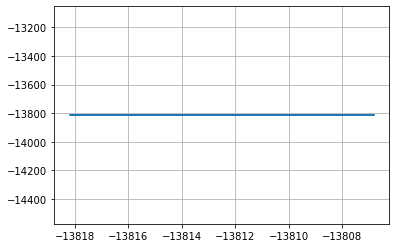

In [40]:
plt.plot(test_labels,prediction)
plt.grid()

In [41]:
print('layer 1')
print('weights')
print(net.network1.fc1.weight)
print('biases')
print(net.network1.fc1.bias)

print('layer 2')
print('weights')
print(net.network1.fc2.weight)
print('biases')
print(net.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 0.6265, -1.2104],
        [ 0.5454,  1.3589],
        [-0.3028,  0.4349],
        [-0.3891,  0.5364],
        [-0.3383,  0.7593],
        [-0.1023,  1.0010]], requires_grad=True)
biases
Parameter containing:
tensor([-2.4525,  0.9139,  2.2151,  2.3051,  2.3853,  1.9449],
       requires_grad=True)
layer 2
weights
Parameter containing:
tensor([[-1.9425, -0.5051,  0.7719,  1.3814,  1.1540,  0.5235],
        [ 2.0360,  0.4650, -1.0732, -1.2938, -0.9800, -0.4856],
        [-0.9587, -0.7811,  1.2996,  1.5007,  1.8339,  0.7415]],
       requires_grad=True)
biases
Parameter containing:
tensor([ 3.7754, -3.6424,  3.4948], requires_grad=True)
